In [ ]:
HTML(read(open("style.html"), String))

In [1]:
include("silent.jl")

@silent (macro with 1 method)

In [2]:
using Pkg
@silent Pkg.add("NBInclude")
using NBInclude
import Chess
import Chess.UCI
import Chess.PGN
@silent Pkg.add("Plots")
import Plots

In [3]:
@nbinclude "2.1 - Board.ipynb"
@nbinclude "2.0 - Gameplay.ipynb"
@nbinclude "3.1 - Evaluation.ipynb"
@nbinclude "5.1 - Alpha-Beta-Pruning AI.ipynb"
@nbinclude "6.0 - Iterative Deepening.ipynb"

getNextMove (generic function with 6 methods)

***

# Testing - Stockfish

Dieses Notebook umfasst Tests gegen die Schach-Engine [`Stockfish 15.1`](https://stockfishchess.org/).

Stockfish ist mit dem [Universal Chess Interface (UCI)](https://www.chessprogramming.org/UCI) Kommunikationsprotokoll kompatibel. Dies ermöglicht es uns, Stockfish über das UCI-Modul der `Chess.jl` Bibliothek einzubinden.

Da es sich bei Stockfish um eine hochgradig optimierte Schach-KI mit einer geschätzten Elo von über 3500 handelt, muss Stockfish für unsere Testzwecke geschwächt werden, um einen gleichwertigen Gegner darstellen zu können.

Die Spielstärke von Stockfish wird unter anderem durch zwei Einstellungen bestimmt:

### Skill Level

Mit der UCI-Option `Skill Level` lässt sich eine Spielstärke `0 - 19` angeben. Bei einem Skill-Level von 19 erreicht Stockfish seine höchste Spielleistung.

### UCI Elo Rating
    
Mit den UCI-Optionen `UCI_LimitStrength` und `UCI_Elo` lässt sich eine ungefähre Spielstärke in Elo-Punkten angeben. Diese Limitierung wird [intern](https://github.com/official-stockfish/Stockfish/blob/d99942f25449789de78c9d36e3dcb67d4eb04e98/src/search.cpp#L93) wie folgt in ein passendes Skill Level konvertiert:

```c++
    double e = double(uci_elo - 1320) / (3190 - 1320);
    level = std::clamp((((37.2473 * e - 40.8525) * e + 22.2943) * e - 0.311438), 0.0, 19.0);
```

Quelle: [github.com/official-stockfish/Stockfish](https://github.com/official-stockfish/Stockfish/blob/d99942f25449789de78c9d36e3dcb67d4eb04e98/src/search.cpp#L101), Abruf am 04.06.2023.

Eine Anzahl von 1500 Elo-Punkten entspricht somit einem Skill-Level von 1,48924. Wie im Source-Code beschrieben, handelt es sich hierbei jedoch lediglich um Annäherungen.

Aus der beschriebenen Formel ergibt sich die folgende Skill-Level-Interpretation:

<table style="width: 70%">
    <tr>
        <th>Skill-Level</th>
        <th>~Elo</th>
    </tr>
    <tr><td>0</td><td>≥ 1320</td></tr>
    <tr><td>1</td><td>≥ 1445</td></tr>
    <tr><td>2</td><td>≥ 1567</td></tr>
    <tr><td>3</td><td>≥ 1729</td></tr>
    <tr><td>4</td><td>≥ 1954</td></tr>
    <tr><td>5</td><td>≥ 2197</td></tr>
    <tr><td>6</td><td>≥ 2383</td></tr>
    <tr><td>7</td><td>≥ 2519</td></tr>
    <tr><td>8</td><td>≥ 2625</td></tr>
    <tr><td>9</td><td>≥ 2712</td></tr>
    <tr><td>10</td><td>≥ 2786</td></tr>
    <tr><td>11</td><td>≥ 2852</td></tr>
    <tr><td>12</td><td>≥ 2910</td></tr>
    <tr><td>13</td><td>≥ 2963</td></tr>
    <tr><td>14</td><td>≥ 3012</td></tr>
    <tr><td>15</td><td>≥ 3057</td></tr>
    <tr><td>16</td><td>≥ 3100</td></tr>
    <tr><td>17</td><td>≥ 3139</td></tr>
    <tr><td>18</td><td>≥ 3177</td></tr>
    <tr><td>19</td><td>≥ 3212</td></tr>
</table>

Um die gewünschte Mindeststärke von 1300 zu erreichen, muss unsere KI Stockfish mit Level 0 bei gleicher Suchtiefe in mindestens 50% der Fälle schlagen (ausgenommen Unentschieden).

# Stockfish KI

Um Stockfish als Spieler einbinden zu können, wird ein eigener KI-Typ definiert, welcher über das `Chess.UCI` Modul auf Stockfish zugreift.

Der Konstruktor `Stockfish(skill::Int, depth::Int = 20)` erstellt eine neue Instanz des Stockfish-Spielers mit einer Skill-Level- und Suchtiefen-Limitierungen (optional).

Der Konstruktor `Stockfish(elo::Int)` erstellt eine neue Instanz des Stockfish-Spielers mit einer Elo-Limitierung. Hierbei wird Stockfish auf eine feste Suchtiefe von 20 (Halbzügen) gesetzt. Dies ermöglicht es Stockfish, gute Zugentscheidungen zu treffen, ohne einen unfairen Vorteil zu erlangen.

In [4]:
struct Stockfish
    engine::Chess.UCI.Engine
    depth::Int
    
    function Stockfish(skill::Int, depth::Int = 20)
        # requires the stockfish executable (f.e. stockfish.exe) to be in PATH
        sf = Chess.UCI.runengine("stockfish")
        Chess.UCI.setoption(sf, "Skill Level", skill)
        return new(sf, depth) 
    end
    
    function Stockfish(elo::Int)
        # requires the stockfish executable (f.e. stockfish.exe) to be in PATH
        sf = Chess.UCI.runengine("stockfish")
        Chess.UCI.setoption(sf, "UCI_LimitStrength", true)
        Chess.UCI.setoption(sf, "UCI_Elo", elo)
        return new(sf, 20) 
    end
end

**Input:**
+ ai &rarr; die Stockfish-KI
+ extboard &rarr; das Spielbrett
+ log &rarr; die zu verwendende Log-Funktion
+ _... &rarr; ein Platzhalter, der es ermöglicht weitere Parameter mitzugeben 

**Output:**
+ move &rarr; der von Stockfish gefundene Zug

In [5]:
function getNextMove(ai::Stockfish, extboard::ExtendedBoard, log::Function, _...)::Chess.Move
    Chess.UCI.setboard(ai.engine, extboard.board)
    return Chess.UCI.search(ai.engine, "go depth $(ai.depth)", infoaction = log).bestmove
end

getNextMove (generic function with 7 methods)

# Aufstellung der Tests

Tests gegen Stockfish werden mit dem folgenden Code durchgeführt. Hierbei tritt die beste Version unserer KI (ABMemoAllAI) mit einer maximalen Suchzeit von 10 Sekunden gegen Stockfish an.

Während diese Zeitlimitierung die Spielstärke unserer KI negativ beeinflusst, ermöglicht sie uns, möglichst viele Spiele zu spielen.

Alle Tests werden mehrfach wiederholt, nach jedem Spiel werden die Farben getauscht.

Gespielte Spiele werden anschließend in entsprechenden Ordnern `./games-$(elo)`, bzw. `./games-$(level)-$(depth)` gespeichert.

Hierbei betrachten wir verschiedene Kombinationen aus Skill-Leveln und Suchtiefen.

**Tests mit Stockfish Elo Limitierung**

In [ ]:
# --- parameter ---
n = 100
elo = 1500
# ---
for x in 1:n
    sf = Stockfish(elo)
    ai = IterativeDeepening(
        ABMemoAllAI, # backing AI Type
        1000,        # max Depth
        10.0,        # max Time in Seconds
        """          # required dependencies for backing AI Type
            using NBInclude
            @nbinclude "3.1 - Evaluation.ipynb"
            @nbinclude "5.1 - Alpha-Beta-Pruning AI.ipynb"
        """
    )
    if x % 2 == 0
        play(white = ai, black = sf, save = "./games-$(elo)")
    else
        play(black = ai, white = sf, save = "./games-$(elo)") 
    end
    cleanup!(ai)
    Chess.UCI.quit(sf.engine)
end

r2q1rk1/ppp1bppp/2n5/4p3/7P/1NP3P1/PP2QP2/R1B1KBNb b Q -


HTML{String}("Board:<div class=\"chessboard\"><style soped=\"true\">.dark-square {\n    fill: #c3936a;\n    stroke-width: 0;\n}\n.light-square {\n    fill: #ffd7a6;\n    stroke-width: 0;\n}\n.highlight {\n    fill: #47d18b;\n}\n@media (prefers-color-scheme: dark) {\n    .dark-square {\n        fill: #00796b;\n    }\n    .light-square {\n        fill: #3ca59b;\n    }\n    .highlight {\n        fill: #d23600;\n    }\n}\n</style><svg style=\"float: left; margin-right: 20px\" viewBox=\"0 0 8 8\" height=\"280\" width=\"280\"><g><g><rect x=\"0\" y=\"0\" class=\"light-square\" height=\"1\" width=\"1\"></rect><image x=\"0\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/br.svg\" y=\"0\" height=\"1\" width=\"1\"></image></g><g><rect x=\"0\" y=\"1\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><image x=\"0\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/bp.svg\" y=\"1\" height=\"1\" width=\"1\"></image></g><g><rect x=\"0\" y=\"2\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"0\" y=\"3\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"0\" y=\"4\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"0\" y=\"5\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"0\" y=\"6\" class=\"light-square\" height=\"1\" width=\"1\"></rect><image x=\"0\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/wp.svg\" y=\"6\" height=\"1\" width=\"1\"></image></g><g><rect x=\"0\" y=\"7\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><image x=\"0\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/wr.svg\" y=\"7\" height=\"1\" width=\"1\"></image></g><g><rect x=\"1\" y=\"0\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"1\" y=\"1\" class=\"light-square\" height=\"1\" width=\"1\"></rect><image x=\"1\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/bp.svg\" y=\"1\" height=\"1\" width=\"1\"></image></g><g><rect x=\"1\" y=\"2\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"1\" y=\"3\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"1\" y=\"4\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"1\" y=\"5\" class=\"light-square\" height=\"1\" width=\"1\"></rect><image x=\"1\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/wn.svg\" y=\"5\" height=\"1\" width=\"1\"></image></g><g><rect x=\"1\" y=\"6\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><image x=\"1\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/wp.svg\" y=\"6\" height=\"1\" width=\"1\"></image></g><g><rect x=\"1\" y=\"7\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"2\" y=\"0\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"2\" y=\"1\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><image x=\"2\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/bp.svg\" y=\"1\" height=\"1\" width=\"1\"></image></g><g><rect x=\"2\" y=\"2\" class=\"light-square\" height=\"1\" width=\"1\"></rect><image x=\"2\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/bn.svg\" y=\"2\" height=\"1\" width=\"1\"></image></g><g><rect x=\"2\" y=\"3\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"2\" y=\"4\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"2\" y=\"5\" class=\"dark-square\" height=\"1\" width=\"1\"></rect><image x=\"2\" xlink:href=\"https://raw.githubusercontent.com/romstad/Chess.jl/master/img/wp.svg\" y=\"5\" height=\"1\" width=\"1\"></image></g><g><rect x=\"2\" y=\"6\" class=\"light-square\" height=\"1\" width=\"1\"></rect><g></g></g><g><rect x=\"2\" y=\"7\" class=\"dark-square\" height=\"1\"

Last Move: Move(h3h4)
Killed worker 733 after 735.1758259 seconds


**Tests mit Stockfish Skill-Level Limitierung**

In [ ]:
# --- parameter ---
n = 100
level = 3
depth = 5
# ---
for x in 1:n
    sf = Stockfish(level, depth)
    ai = IterativeDeepening(
        ABMemoAllAI, # backing AI Type
        1000,        # max Depth
        10.0,        # max Time in Seconds
        """          # required dependencies for backing AI Type
            using NBInclude
            @nbinclude "3.1 - Evaluation.ipynb"
            @nbinclude "5.1 - Alpha-Beta-Pruning AI.ipynb"
        """
    )
    if x % 2 == 0
        play(white = ai, black = sf, save = "./games-$(level)-$(depth)")
    else
        play(black = ai, white = sf, save = "./games-$(level)-$(depth)")
    end
    cleanup!(ai)
    Chess.UCI.quit(sf.engine)
end

Um zu gewährleisten, dass es sich bei den gespielten Testspielen um einzigartige Spiele handelt, prüfen wir alle Spiele unter einer gegebenen Konfiguration auf Duplikate. Das Vorkommen eines Duplikates invalidiert keinesfalls die erspielten Ergebnisse, dennoch sollte die Anzahl aller Duplikate gering ausfallen, um ein zuverlässiges Ergebnis zu liefern.

In [22]:
for gameSet in readdir()
    if !startswith(gameSet, "games-")
        continue
    end
    println("validating $gameSet")
    knownGames = []
    i = 1
    for game in readdir(gameSet)
        if !endswith(game, ".pgn")
            continue
        end
        pgn = read(gameSet * "/" * game, String)
        i += 1
        if pgn in knownGames
            println("found a duplicate: $gameSet/$game")
        else
            push!(knownGames, pgn)
        end
    end
    println("checked $(length(knownGames)) games")
end

validating games-1-20
checked 46 games
validating games-1-4
checked 10 games
validating games-1-5
checked 40 games
validating games-1-6
checked 54 games
validating games-1500
checked 39 games
validating games-2-20
checked 20 games
validating games-2-4
checked 20 games
validating games-2-5
checked 20 games
validating games-3-5
checked 22 games
validating games-4-5
checked 10 games


Unter einer gegebenen Konfiguration bestimmen wir die Siegrate mit der Funktion `getWinRate`.

**Input:**
+ folder &rarr; der Ordner mit allen Spielen, z.B. "games-1500" oder "games-1-3"

**Output:**
+ die Siegrate unserer KI, Wert zwischen 0.0 und 1.0

In [8]:
function getWinRate(folder::String)::Float64
    results = Dict(:SF_White => 0, :SF_Black => 0, :AI_White => 0, :AI_Black => 0, :Draw => 0)
    for file in readdir(folder, sort = true)
        stream = open("$(folder)/$(file)", "r")
        game = Chess.PGN.readgame(Chess.PGN.PGNReader(stream))
        close(stream)
        board = last(Chess.boards(game))
        if Chess.isdraw(board)
            results[:Draw] += 1
        elseif Chess.sidetomove(board) == Chess.WHITE
            if startswith(Chess.headervalue(game, "Black"), "IterativeDeepening")
                results[:AI_Black] += 1
            else
                results[:SF_Black] += 1
            end
        else
            if startswith(Chess.headervalue(game, "Black"), "IterativeDeepening")
                results[:SF_White] += 1
            else
                results[:AI_White] += 1
            end
        end
    end
    totalNoDrawsAI = results[:AI_White] + results[:AI_Black]
    totalNoDrawsSF = results[:SF_White] + results[:SF_Black]
    totalNoDraws = totalNoDrawsAI + totalNoDrawsSF
    println("$(folder):")
    println("\t$(results)")
    println("\tWins:    $(round(((results[:AI_White] + results[:AI_Black]) / totalNoDraws) * 100, digits = 2)
        )% (excluding draws, of which $(round((results[:AI_White] / totalNoDrawsAI) * 100, digits = 2)
        )% as White, $(round((results[:AI_Black] / totalNoDrawsAI) * 100, digits = 2))% as Black)")
    println("\tDefeats: $(round(((results[:SF_White] + results[:SF_Black]) / totalNoDraws) * 100, digits = 2)
        )% (excluding draws, of which $(round((results[:SF_Black] / totalNoDrawsSF) * 100, digits = 2)
        )% as White, $(round((results[:SF_White] / totalNoDrawsSF) * 100, digits = 2))% as Black)")
    println("\tDraws:   $(round((results[:Draw] / (totalNoDraws + results[:Draw])) * 100, digits = 2))% (all games)")
    return (results[:AI_White] + results[:AI_Black]) / totalNoDraws
end

getWinRate (generic function with 1 method)

Aus den Konfigurationen Skill-Level + Suchtiefe ergibt sich der folgende Graph:

games-1-4:
	Dict(:AI_Black => 5, :Draw => 0, :SF_Black => 1, :AI_White => 4, :SF_White => 0)
	Wins:    90.0% (excluding draws, of which 44.44% as White, 55.56% as Black)
	Defeats: 10.0% (excluding draws, of which 100.0% as White, 0.0% as Black)
	Draws:   0.0% (all games)
games-1-5:
	Dict(:AI_Black => 17, :Draw => 1, :SF_Black => 2, :AI_White => 17, :SF_White => 3)
	Wins:    87.18% (excluding draws, of which 50.0% as White, 50.0% as Black)
	Defeats: 12.82% (excluding draws, of which 40.0% as White, 60.0% as Black)
	Draws:   2.5% (all games)
games-1-6:
	Dict(:AI_Black => 21, :Draw => 3, :SF_Black => 2, :AI_White => 23, :SF_White => 5)
	Wins:    86.27% (excluding draws, of which 52.27% as White, 47.73% as Black)
	Defeats: 13.73% (excluding draws, of which 28.57% as White, 71.43% as Black)
	Draws:   5.56% (all games)
games-1-20:
	Dict(:AI_Black => 15, :Draw => 2, :SF_Black => 5, :AI_White => 17, :SF_White => 7)
	Wins:    72.73% (excluding draws, of which 53.12% as White, 46.88% as Black)
	

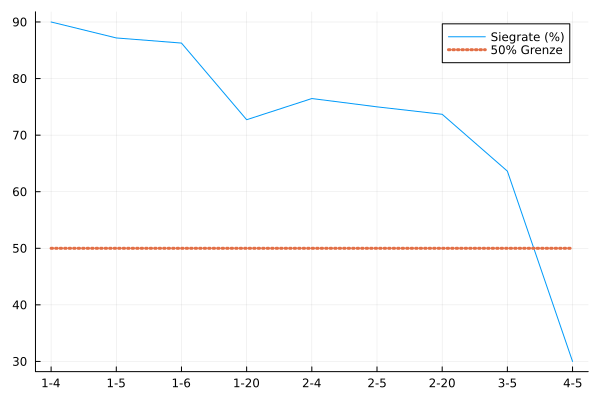

In [16]:
gameSets = []
for gameSet in readdir()
    if match(r"games-\d+-\d+", gameSet) == nothing
        continue
    end
    push!(gameSets, gameSet)
end
gameSets = sort(gameSets, by=name -> parse(Int, split(name, "-")[2]) * 100 + parse(Int, split(name, "-")[3]))

winrates = [getWinRate(gameSet) * 100 for gameSet in gameSets]
configs = [gameSet[7:length(gameSet)] for gameSet in gameSets]
Plots.plot(configs, winrates, label = "Siegrate (%)")
Plots.plot!(configs, _ -> 50, label = "50% Grenze", lw=3, ls=:dot)

Siegrate unserer KI bei gleicher Suchtiefe (5) mit Skill-Leveln 1 bis 4:

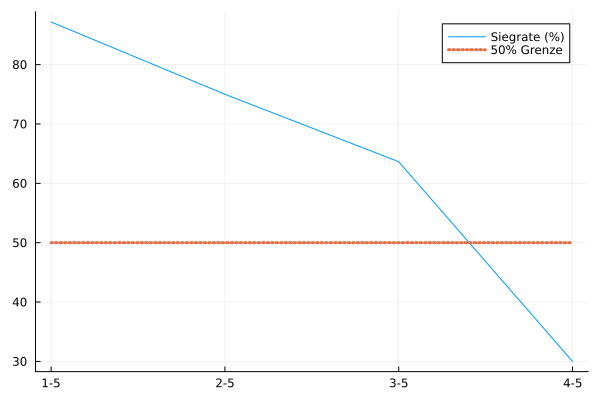

In [17]:
depth5Rates = filter(element -> endswith(element[1], "5"), [zip(configs, winrates)...])
Plots.plot([element[1] for element in depth5Rates], [element[2] for element in depth5Rates], label = "Siegrate (%)")
Plots.plot!([element[1] for element in depth5Rates], _ -> 50, label = "50% Grenze", lw=3, ls=:dot)

Siegrate gegen Stockfish mit 1500 Elo-Punkten:

In [20]:
getWinRate("games-1500")

games-1500:
	Dict(:AI_Black => 10, :Draw => 0, :SF_Black => 9, :AI_White => 10, :SF_White => 10)
	Wins:    51.28% (excluding draws, of which 50.0% as White, 50.0% as Black)
	Defeats: 48.72% (excluding draws, of which 47.37% as White, 52.63% as Black)
	Draws:   0.0% (all games)


0.5128205128205128

Unsere KI ist gegen Stockfish mit den Konfigurationen Skill-Level 1, Skill-Level 2 und 1500 Elo-Punkten mit einer Suchtiefe von 20 in der Lage, eine Siegrate > 50% zu erzielen. Daraus ist zu folgern, dass die Elo unserer KI über 1300 Punkten liegt.

An dem Vergleich der Konfiguration Skill-Level 2 (1567 Elo) und Elo 1500 zeigt sich die Wichtigkeit einer großen Testmenge. Während die 20 gespielten Spiele bei Skill-Level 2 mit einer Siegrate von 73.68% zunächst auf eine Überlegenheit unserer KI deuten, zeigen die 39 gespielten Spiele bei 1500 Elo-Punkten ein eher ebenbürtiges Bild. Je mehr Testspiele gespielt werden, desto genauer wird sich die Siegrate dem Erwartungswert annähern.

Eine genaue Abschätzung der Elo-Punkte unserer KI erfordert es, durch weitreichendes Testen eine Schwelle zu finden, welche eine konstante Siegrate (Sieg vs. Niederlage, ohne Unentschieden) von 50% aufweist. Aus Zeitgründen wurde diese Evaluierung nicht durchgeführt.

Die Testergebnisse zeigen, dass die Spielstärke über den geforderten 1300 Elo-Punkten liegt.